In [1]:
import freegs
from freegs.machine import Coil, Solenoid, Circuit, Wall

Define the position of the 4 Poloidal coils
- The position of the coils is defined in Harvey's Thesis Page 36 and 37 in Tables 14 and 15.
- More information on Page 72 in Table 01

In [2]:
PR1 = 0.50738376
PZ1 = 0.39384023
PR2 = 0.62576723
PZ2 = 0.1996288

In [3]:
poloidal_coils = [
    (
        "VERT", Circuit([
            ("VERT_U", Coil(PR1, PZ1), 1.0),
            ("VERT_L", Coil(PR1, -PZ1), 1.0)
        ])
    ),
    (
        "HORIZ", Circuit([
            ("HORIZ_U", Coil(PR2, PZ2), 1.0),
            ("HORIZ_L", Coil(PR2, -PZ2), 1.0)
        ])
    )
]

Define the central solenoid
- Position of the coils are defined in Harvey's Thesis Pg30 in Table 9

In [4]:
solenoid_height = 0.94
inner_radius = 51e-3
outer_radius = 60e-3
solenoid_turns = 104

In [5]:
central_solenoid = [("SOL", Solenoid((inner_radius + outer_radius) / 2, -solenoid_height / 2,  solenoid_height / 2, solenoid_turns, control=False))]

Define the position of the Vacuum Chamber 

In [6]:
walls = Wall(
    [0.160,0.1761,0.2200,0.280,0.3400,0.3839,0.40, 0.3839, 0.3400, 0.280, 0.2200, 0.1761 ],   # R
    [0.000,0.0600,0.1039,0.120,0.1039,0.0600,0.00,-0.0600,-0.1039,-0.120,-0.1039,-0.0600]     # Z
)

Define position of sensors

In [7]:
tokamak = freegs.machine.Machine(
    central_solenoid + poloidal_coils,
    walls
)

In [8]:
tokamak["VERT"]["VERT_U"].area = tokamak["VERT"]["VERT_L"].area = tokamak["HORIZ"]["HORIZ_U"].area = tokamak["HORIZ"]["HORIZ_L"].area = 0.000213825*4

In [9]:
eq = freegs.Equilibrium(tokamak=tokamak,
                        Rmin=0.01, Rmax=0.6,    # Radial domain
                        Zmin=-0.5, Zmax=0.5,   # Height range
                        nx=65, ny=65          # Number of grid points
                        )

Plasma Current 
- Current induced by ions and electrons in the plasma

Plasma Poloidal Beta
- Ratio of plasma pressure to magnetic pressure

Vacuum f (Vacuum Toroidal Magnetic Field)
- Refers to the magnetic field strength in the toroidal direction in a vacuum or absence of plasma
- R = to major radius of Tokamak
- B_t = Toroidal magnetic field 

In [10]:
plasma_major_radius = 0.28
toroidal_magnetic_field_strength_at_plasma_centre = 0.875
vacuum_toroidal_magnetic_field = plasma_major_radius * toroidal_magnetic_field_strength_at_plasma_centre

In [11]:
profiles = freegs.jtor.ConstrainBetapIp(eq,
                                        0.05, # Plasma poloidal beta
                                        3e3, # Plasma current [Amps]
                                        vacuum_toroidal_magnetic_field) # Vacuum f=R*Bt

X-points
- Refers to points where magnetic field strength is zero / where magnetic field lines intersect

Isoflux 
- Refers to condition where magnetic flux remains constant or uniform in a given region

In [12]:
xpoints = [(0.3, -0.24), (0.3, 0.24)]  # (R,Z) locations of X-points

isoflux = [(0.3, -0.24, 0.3, 0.24)] # (R1,Z1, R2,Z2) pairs

In [13]:
constrain = freegs.control.constrain(xpoints=xpoints, isoflux=isoflux)

'check_limited' refers to checking if the plasma is confined or not

In [14]:
freegs.solve(eq,
            profiles, 
            constrain,
            show=False,
            check_limited=True,
            limit_it = 0
)

Understanding the diagram below:
- X-points
    - Refers to where magnetic field lines intersect for the plasma (or where magnetic field strength becomes 0)
    - Indicate regions where plasma is unstable or undergoes reconnection
- Separatrix
    - A boundary where within a plasma that separates regions of different magnetic topology.
- O-points 
    - Locations where magnetic field lines form a loop.
        - Indicate regions where magnetic field strength are weak and can impact plasma stability      

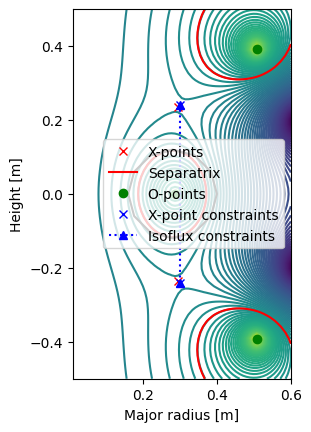

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [15]:
axis = eq.plot(show=False)
eq.tokamak.plot(axis=axis, show=False)
constrain.plot(axis=axis, show=True)

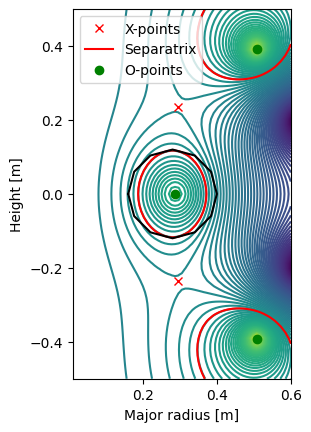

In [16]:
axis = eq.plot(show=True)

In [17]:
print(f"Plasma current: {eq.plasmaCurrent():.2E} Amps")
print(f"Plasma pressure on axis: {(eq.pressure(0.0)):.2E} Pascals")
print(f"Poloidal beta: {eq.poloidalBeta():.2E}")

Plasma current: 3.00E+03 Amps
Plasma pressure on axis: 6.87E+00 Pascals
Poloidal beta: 5.10E-02


In [23]:
tokamak.printCurrents()

SOL : Solenoid(Rs=0.055499999999999994, Zsmin=-0.47, Zsmax=0.47, current=0.0, Ns=104, control=False)
VERT : Circuit([("VERT_U", Coil(R=0.50738376, Z=0.39384023, current=2588.6, turns=1, control=True), 1.0), ("VERT_L", Coil(R=0.50738376, Z=-0.39384023, current=2588.6, turns=1, control=True), 1.0)], current=2588.624220101801, control=True)
HORIZ : Circuit([("HORIZ_U", Coil(R=0.62576723, Z=0.1996288, current=-2800.6, turns=1, control=True), 1.0), ("HORIZ_L", Coil(R=0.62576723, Z=-0.1996288, current=-2800.6, turns=1, control=True), 1.0)], current=-2800.6019958295324, control=True)


In [21]:
tokamak.getForces(eq)

{'SOL': {},
 'VERT': {'VERT_U': array([28.54805073, 15.85978099]),
  'VERT_L': array([ 28.54805073, -15.85978099])},
 'HORIZ': {'HORIZ_U': array([ 70.35944386, -20.12484117]),
  'HORIZ_L': array([70.35944386, 20.12484115])}}

In [20]:
eq.intersectsWall()

False